# FIT5202 2025 S2 Assignment 1 : Analysing Australian Property Market Data

## Table of Contents
* [Part 1 : Working with RDD](#part-1)  
    - [1.1 Data Preparation and Loading](#1.1)  
    - [1.2 Data Partitioning in RDD](#1.2)  
    - [1.3 Query/Analysis](#1.3)  
* [Part 2 : Working with DataFrames](#2-dataframes)  
    - [2.1 Data Preparation and Loading](#2-dataframes)  
    - [2.2 Query/Analysis](#2.2)  
* [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)  

Note: Feel free to add Code/Markdown cells as you need.

# Part 1 : Working with RDDs (30%) <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries. 

1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
1.	Write the code to create a SparkContext object using SparkSession. To create a SparkSession, you first need to build a SparkConf object that contains information about your application. Use Melbourne time as the session timezone. Give your application an appropriate name and run Spark locally with 4 cores on your machine.

In [1]:
#Importing libraries
from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

master = "local[4]"
app_name = "Assignment 1"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Spark Session setup
spark = (
    SparkSession.builder
    .config(conf=spark_conf)
    .config("spark.sql.session.timeZone", "Australia/Melbourne")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel('ERROR')

1.1.2 Load the CSV and JSON files into multiple RDDs. 

In [2]:
import json
#Loading nsw_property_price csv file
prop_price_rdd_lines = sc.textFile('A1_data/nsw_property_price.csv')


# Reading council into rdd and parsing each record
with open("A1_data/council.json", "r") as f:
    council_data = json.load(f)   # parse entire JSON

council_records = council_data["council_id,council_name\n"]
council_rdd_lines = sc.parallelize(council_records)
council_rdd = council_rdd_lines.map(lambda x: (x["council_id"], x['council_name']))

# Zoning
with open("A1_data/zoning.json", "r") as f:
    zoning_data = json.load(f)   # parse entire JSON

zoning_records = zoning_data["zoning_id, zoning\n"]
zoning_rdd_lines = sc.parallelize(zoning_records)
zoning_rdd = zoning_rdd_lines.map(lambda x: (x["zoning_id"], x["zoning"]))

# Property_house
with open("A1_data/property_purpose.json", "r") as f:
    prop_purpose_data = json.load(f)   # parse entire JSON

prop_purpose_records = prop_purpose_data["purpose_id, primary_purpose\n"]
prop_purpose_rdd_lines = sc.parallelize(prop_purpose_records)
prop_purpose_rdd = prop_purpose_rdd_lines.map(lambda x: (x["purpose_id"], x["primary_purpose"]))

1.1.3 For each RDD, remove the header rows and display the total count and the first 8 records.


In [3]:
#Removing header from csv file and parsing each record
prop_price_rdd = prop_price_rdd_lines.map(lambda line: line.replace('"','').split(','))
header = prop_price_rdd.first()
prop_price_rdd_1 = prop_price_rdd.filter(lambda x: x != header)

rdd_dict = {
            "prop_price" : prop_price_rdd_1,
            "council" : council_rdd,
            "zoning" : zoning_rdd,
            "prop_purpose" : prop_purpose_rdd
           }

for name, rdd in rdd_dict.items() :
    print(f'File: {name}')
    print(f'The file contains {rdd.count()} records')
    print(f'First 8 records : \n {rdd.take(8)}')
    print('------------------------------------------')

File: prop_price
The file contains 4854814 records
First 8 records : 
 [['4270509', '1400000.00', '8 C NYARI RD', ' KENTHURST', '2156', 'house', '', '', '2.044', 'H', '2023-12-14', '2024-02-14', 'V', '2/1229857', '142', '200', '9922', '53'], ['4329326', '1105000.00', '82 CAMARERO ST', ' BOX HILL', '2765', 'house', '', '', '300.2', 'M', '2024-01-12', '2024-02-09', 'R', '1119/1256791', '143', '200', '7071', '41'], ['1864112', '55000.00', '321 AUBURN ST', ' MOREE', '2400', 'house', '', '', '847.3', 'M', '2023-09-15', '2024-01-29', 'R', '17/36061', '192', '168', '7071', '40'], ['1869899', '680000.00', '207 GWYDIRFIELD RD', ' MOREE', '2400', 'house', '', 'SPRINGVALE', '2.023', 'H', '2024-01-19', '2024-02-09', 'R', '6/251911', '193', '168', '7071', '48'], ['1867775', '220000.00', '90 MERRIWA ST', ' BOGGABILLA', '2409', 'house', '', '', '2023.0', 'M', '2023-12-08', '2024-02-09', 'R', '1/1/758127', '194', '168', '7071', '52'], ['2738374', '690000.00', '10 PETOSTRUM PL', ' PORT MACQUARIE', '244

1.1.4 Drop records with invalid information: purpose_id or council_id is null, empty, or 0.

In [4]:
#Filtering records with invalid informations
prop_purpose_rdd = prop_purpose_rdd.filter(lambda x : str(x[0]) not in ['', '0'])
council_rdd = council_rdd.filter(lambda x: str(x[0]) not in ['', '0'])
print(f'New count purpose records : {prop_purpose_rdd.count()}')
print(f'New count council records : {council_rdd.count()}')

New count purpose records : 865
New count council records : 220


### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, using Spark’s default partitioning, print out the total number of partitions and the number of records in each partition

In [5]:
def count_partition(index, iterator):
    count = sum(1 for _ in iterator)
    yield (index, count)

for name,rdd in rdd_dict.items() :
    
    num_part = rdd.getNumPartitions()
    partition_sizes = rdd.mapPartitionsWithIndex(count_partition).collect()
    
    print(f'File: {name}')
    print(f'Number of Partitions: {num_part}')
    for idx, size in partition_sizes:
        print(f"    Partition {idx} has {size} records")
    print('---------------------------------------------')

File: prop_price
Number of Partitions: 19
    Partition 0 has 257607 records
    Partition 1 has 256639 records
    Partition 2 has 254980 records
    Partition 3 has 255421 records
    Partition 4 has 255733 records
    Partition 5 has 258234 records
    Partition 6 has 258938 records
    Partition 7 has 257430 records
    Partition 8 has 255506 records
    Partition 9 has 254836 records
    Partition 10 has 254545 records
    Partition 11 has 253253 records
    Partition 12 has 253529 records
    Partition 13 has 255264 records
    Partition 14 has 254225 records
    Partition 15 has 257945 records
    Partition 16 has 257445 records
    Partition 17 has 255829 records
    Partition 18 has 247455 records
---------------------------------------------
File: council
Number of Partitions: 4
    Partition 0 has 55 records
    Partition 1 has 55 records
    Partition 2 has 55 records
    Partition 3 has 55 records
---------------------------------------------
File: zoning
Number of Partiti

1.2.2 Answer the following questions:   
a) How many partitions do the above RDDs have?  
b) How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain why it is partitioned in this number?   
c) Assuming we are querying the dataset based on <strong> Property Price</strong>, can you think of a better strategy for partitioning the data based on your available hardware resources?  

**(a)** For the json files, with smaller data size (as we can see looking at the record count), we observe a number of partitions equal to the number of cores, that is 4 partitions. The property size file is partitioned differently, and is divided across 19 partitions (approximatively 5 times the number of cores allocated), each containing roughly 250000 records. 


**(b)** By default, sc.parallelize() will refer to the setting contained in sc.defaultParallelism to define the number of partitions. The value is equal to the number of cores assigned to out spark configuration, and it assumes the value of 4 in this case. By default a round-robin equal partitioning method has been used to divide the data. For the csv file that is different, as it was read with sc.textFile(), which partitions the data based on the hadoop file system block size, with each partition being more of less equal to 32 MB in this case.

**(c)** If we are specifically querying for Property Price values, it would be a better strategy to partition the data based on a **range partitioning** on the property_price attribute. This way, It will be much easier to search for specific values or in a range, as we'd already know their location. Since range partitioning is not balanced, we want to assign ranges containing more records to the more performant cores.

1.2.3 Create a user-defined function (UDF) to transform the date strings from ISO format (YYYY-MM-DD) (e.g. 2025-01-01) to Australian format (DD/Mon/YYYY) (e.g. 01/Jan/2025), then call the UDF to transform two date columns (iso_contract_date and iso_settlement_date) to contract_date and settlement_date.

In [6]:
from datetime import datetime

#function to reformat date from iso to Aus format
def format_date(date):
    try:
        return datetime.strptime(date, "%Y-%m-%d").strftime("%d/%b/%Y")
    except ValueError:
        return "" 

#implementing format to rows 10 and 11 (date rows)
prop_price_rdd_aus = prop_price_rdd_1.map(lambda row: row[:10] + [format_date(row[10])] + [format_date(row[11])] + row[12:])
prop_price_rdd_aus.take(5)

[['4270509',
  '1400000.00',
  '8 C NYARI RD',
  ' KENTHURST',
  '2156',
  'house',
  '',
  '',
  '2.044',
  'H',
  '14/Dec/2023',
  '14/Feb/2024',
  'V',
  '2/1229857',
  '142',
  '200',
  '9922',
  '53'],
 ['4329326',
  '1105000.00',
  '82 CAMARERO ST',
  ' BOX HILL',
  '2765',
  'house',
  '',
  '',
  '300.2',
  'M',
  '12/Jan/2024',
  '09/Feb/2024',
  'R',
  '1119/1256791',
  '143',
  '200',
  '7071',
  '41'],
 ['1864112',
  '55000.00',
  '321 AUBURN ST',
  ' MOREE',
  '2400',
  'house',
  '',
  '',
  '847.3',
  'M',
  '15/Sep/2023',
  '29/Jan/2024',
  'R',
  '17/36061',
  '192',
  '168',
  '7071',
  '40'],
 ['1869899',
  '680000.00',
  '207 GWYDIRFIELD RD',
  ' MOREE',
  '2400',
  'house',
  '',
  'SPRINGVALE',
  '2.023',
  'H',
  '19/Jan/2024',
  '09/Feb/2024',
  'R',
  '6/251911',
  '193',
  '168',
  '7071',
  '48'],
 ['1867775',
  '220000.00',
  '90 MERRIWA ST',
  ' BOGGABILLA',
  '2409',
  'house',
  '',
  '',
  '2023.0',
  'M',
  '08/Dec/2023',
  '09/Feb/2024',
  'R',
  '1/1/

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

1.3.1 Extract the Month (Jan-Dec) information and print the total number of sales by contract date for each Month. (5%)

In [7]:
#Creating tuples month-value and then summing the counts for each month
rdd_month = (
    prop_price_rdd_aus
    .filter(lambda row: row[10] != "") #filtering out rows with empty dates (we do not show them)  
    .map(lambda row: (row[10].split('/')[1], 1))
)
#Finding the count(sum of values) for each month (Key)
sales_by_month = rdd_month.reduceByKey(lambda a, b: a + b)

#Dort using datetime month number
sales_by_month_sorted = sales_by_month.sortBy(lambda x: datetime.strptime(x[0], "%b"))

# Print the result
print("Total sales by month:")
for month, count in sales_by_month_sorted.collect():
    print(f"{month}: {count} sales")

Total sales by month:
Jan: 232367 sales
Feb: 386985 sales
Mar: 462801 sales
Apr: 384058 sales
May: 451690 sales
Jun: 410184 sales
Jul: 406332 sales
Aug: 415393 sales
Sep: 425075 sales
Oct: 434271 sales
Nov: 448828 sales
Dec: 392954 sales


1.3.2 Which 5 councils have the largest number of houses? Show their name and the total number of houses. (Note: Each house may appear multiple times if there are more than one sales, you should only count them once.) (5%)

In [8]:
#NOTE : Council_id is on row[15] for prop_trans, property_id is on row[0]
prop_council = prop_price_rdd_aus.map(lambda row: (row[0], row[15])) #result will be (property_id,council_id)
distinct_props = prop_council.distinct()

# Computing the counts of the number of distinct properties per council
prop_counts = distinct_props.map(lambda x: (x[1], 1)) \
                       .reduceByKey(lambda a, b: a + b)

# Sorting rdd by council_id and collecting top 5 entries, then joining with council_rdd to get the council names
sorted_prop_counts = prop_counts.sortBy(lambda x: x[1], ascending=False)
top_5_councils = sorted_prop_counts.take(5)
top_5_rdd = sc.parallelize(top_5_councils)
top_5_rdd = top_5_rdd.map(lambda x: (int(x[0]),x[1])) #converting id into int to match council_rdd type
top5_with_names = top_5_rdd.join(council_rdd)

collected_rdd = top5_with_names.collect()

#Sort result and print
sorted_list = sorted(collected_rdd, key=lambda x: x[1][0], reverse=True)
for council_id, (count, name) in sorted_list:
    print(f"{name} : {count} distinct properties")
    

BLACKTOWN : 89801 distinct properties
LAKE MACQUARIE : 57969 distinct properties
THE HILLS SHIRE : 54952 distinct properties
LIVERPOOL : 48828 distinct properties
PENRITH : 46631 distinct properties


## Part 2. Working with DataFrames (45%) <a class="anchor" name="2-dataframes"></a>
In this section, you need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

2.1.1. Load the CSV/JSON files into separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each column.

2.1.2 Display the schema of the dataframes.

In [9]:
from pyspark.sql.functions import explode, col

#Loading each file and prining their schema
prop_price_schema = ( 
    "property_id STRING, "
    "purchase_price DOUBLE,"
    "address STRING, "
    "post_code STRING, "
    "property_type STRING, "
    "strata_lot_number STRING,"
    "property_name STRING,"
    "area DOUBLE,"
    "area_type STRING ,"
    "iso_contract_date DATE,"
    "iso_settlement_date DATE,"
    "nature_of_property STRING,"
    "legal_description STRING,"
    "id STRING,"
    "council_id STRING,"
    "purpose_id STRING,"
    "zone_id STRING"
)
prop_price_df = spark.read.csv("A1_data/nsw_property_price.csv",header=True,schema=prop_price_schema,sep=',')
prop_price_df.printSchema()
prop_price_df.show(5)

# Read the JSON files and parsing the format
council_df = spark.read.option("multiLine", True).json("A1_data/council.json")
council_df = council_df.select(explode(col("council_id,council_name\n")).alias("c")) #needed to parse "header" lines correctly
council_df = council_df.select("c.council_id", "c.council_name")
council_df = council_df.withColumn("council_id", col("council_id").cast("string")) #converting id to string
council_df.printSchema()

purpose_df = spark.read.format("json").option("multiLine", True).load("A1_data/property_purpose.json")
purpose_df = purpose_df.select(explode(col("purpose_id, primary_purpose\n")).alias("p"))
purpose_df = purpose_df.select("p.purpose_id", "p.primary_purpose")
purpose_df = purpose_df.withColumn("purpose_id", col("purpose_id").cast("string"))
purpose_df.printSchema()

zoning_df = spark.read.format("json").option("multiLine", True).load("A1_data/zoning.json")
zoning_df = zoning_df.select(explode(col("zoning_id, zoning\n")).alias("z"))
zoning_df = zoning_df.select("z.zoning_id", "z.zoning")
zoning_df = zoning_df.withColumn("zoning_id", col("zoning_id").cast("string"))
zoning_df.printSchema()



root
 |-- property_id: string (nullable = true)
 |-- purchase_price: double (nullable = true)
 |-- address: string (nullable = true)
 |-- post_code: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- strata_lot_number: string (nullable = true)
 |-- property_name: string (nullable = true)
 |-- area: double (nullable = true)
 |-- area_type: string (nullable = true)
 |-- iso_contract_date: date (nullable = true)
 |-- iso_settlement_date: date (nullable = true)
 |-- nature_of_property: string (nullable = true)
 |-- legal_description: string (nullable = true)
 |-- id: string (nullable = true)
 |-- council_id: string (nullable = true)
 |-- purpose_id: string (nullable = true)
 |-- zone_id: string (nullable = true)

+-----------+--------------+--------------------+---------+-------------+-----------------+-------------+------+---------+-----------------+-------------------+------------------+-----------------+---+----------+----------+-------+
|property_id|purchase_pri

When the dataset is large, do you need all columns? How to optimize memory usage? Do you need a customized data partitioning strategy? (Note: Think about those questions but you don’t need to answer these questions.)

### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like transforming, filtering, sorting, joining and group by using the functions provided by the DataFrame API. For each task, display the first 5 results where no output is specified.

2.2.1. The area column has two types: (H, A and M): 1 H is one hectare = 10000 sqm, 1A is one acre = 4000 sqm, 1 M is one sqm. Unify the unit to sqm and create a new column called area_sqm. 

In [10]:
from pyspark.sql.functions import when

# Add new area_sqm column with values dependant on area_type and area
prop_price_df = prop_price_df.withColumn(
    "area_sqm",
    when(col("area_type") == "H", col("area") * 10000) \
    .when(col("area_type") == "A", col("area") * 4000) \
    .when(col("area_type") == "M", col("area")) \
    .otherwise(None)  # in case value is missing
)

#Result
prop_price_df.select("area", "area_type", "area_sqm").show(5)

+------+---------+--------+
|  area|area_type|area_sqm|
+------+---------+--------+
| 2.044|        H| 20440.0|
| 300.2|        M|   300.2|
| 847.3|        M|   847.3|
| 2.023|        H| 20230.0|
|2023.0|        M|  2023.0|
+------+---------+--------+
only showing top 5 rows



2.2.2. <pre>The top five property types are: Residence, Vacant Land, Commercial, Farm and Industrial.
However, for historical reason, they may have different strings in the database. Please update the primary_purpose with the following rules:
a)	Any purpose that has “HOME”, “HOUSE”, “UNIT” is classified as “Residence”;
b)	“Warehouse”, “Factory”,  “INDUST” should be changed to “Industrial”;
c)	Anything that contains “FARM”(i.e. FARMING), should be changed to “FARM”;
d)	“Vacant”, “Land” should be “Vacant Land”;
e)	Anything that has “COMM”, “Retail”, “Shop” or “Office” are “Cmmercial”.
f)	All remaining properties, including null and empty purposes, are classified as “Others”.
Show the count of each type in a table.
(note: Some properties are multi-purpose, e.g. “House & Farm”, it’s fine to count them multiple times.)
</pre>

In [11]:
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

#Defines array containing each classification applicable to the purpose within each row (for example HOME SHOP would be 
# classified as [Commercial,Residence])
purpose_df_new = purpose_df.withColumn(
    "class",
    #NOTE: With this definition, "Warehouse" will be recognised as both Residence and Industrial
    F.expr("""
        filter(
            array(
                IF(primary_purpose RLIKE '(?i)HOME|HOUSE|UNIT|Residence', 'Residence', NULL),
                IF(primary_purpose RLIKE '(?i)COMM|SHOP|RETAIL|OFFICE', 'Commercial', NULL),
                IF(primary_purpose RLIKE '(?i)FARM', 'Farm', NULL),
                IF(primary_purpose RLIKE '(?i)VACANT|LAND', 'Vacant Land', NULL),
                IF(primary_purpose RLIKE '(?i)Warehouse|Factory|INDUST', 'Industrial', NULL)
            ),
            x -> x IS NOT NULL
        )
    """)
)

#If no purpose is found from list, set to "Others"
purpose_df_new = purpose_df_new.withColumn(
    "class",
    F.when(F.size("class") == 0, F.array(F.lit("Others"))).otherwise(F.col("class"))
)

# Explode array with different classifications found in multiple rows
purpose_df_new = purpose_df_new.withColumn("class_2", F.explode("class"))

#Performing left join
#NOTE: We selected only the "purpose_id" column from prop_price before joining to avoid utilising more memory than needed
#Used broadcast join since the purpose dataframe is considerably smaller than prop_price_df
prop_price_reduced = prop_price_df.select("purpose_id")
prop_purpose_joined = prop_price_reduced.join(broadcast(purpose_df_new), on="purpose_id", how="left")

#Aggregation and computation of the totals for each row
agg_attribute = 'class_2'
count_by_purpose = (
    prop_purpose_joined
    .groupby("class_2")
    .agg(F.count("class_2").alias("Total"))
    .filter(F.col("class_2").isNotNull())  # remove NULLs from table
)
count_by_purpose.show()

+-----------+-------+
|    class_2|  Total|
+-----------+-------+
|       Farm|  72782|
|Vacant Land| 558994|
| Industrial|  37070|
|     Others| 140232|
| Commercial| 136896|
|  Residence|3907463|
+-----------+-------+



2.2.3 Find the top 20 properties that make the largest value gain, show their address, suburb, and value increased. To calculate the value gain, the property must have been sold multiple times, “value increase” can be calculated with the last sold price – first sold price, regardless the transactions in between. Print all 20 records.

In [12]:
#Selecting only what we need to perform the operations, to avoid wasting space
property_df = prop_price_df.select("property_id","address","purchase_price","iso_contract_date") #NOTE: address already contains the suburb

prices = property_df.groupBy("property_id").agg(
    F.min_by("purchase_price","iso_contract_date").alias("first_price"), #finding prices paired with first/last date
    F.max_by("purchase_price","iso_contract_date").alias("last_price"),
    F.first("address").alias("address"), #only take first address instead of grouping by address in case of spelling errors
    F.count("*").alias("num_sales")
)

#Filtering out Null ids and houses sold only once(computation does not apply)
filtered_prices = prices.filter(
    (F.col("num_sales") > 1) & 
    (F.col("property_id").isNotNull())
) 
filtered_prices = filtered_prices.withColumn("value_gain", F.col("last_price") - F.col("first_price")) #Value gain computation

#Ordering and getting only top 20 entries
top_20_prop = filtered_prices.orderBy(F.col("value_gain").desc()).limit(20)
top_20_prop = top_20_prop.withColumn("suburb", F.split(F.col("address"), ",\s*").getItem(1)) #adding suburb
top_20_prop = top_20_prop.select("address","suburb","value_gain")
top_20_prop.show(truncate = False)

+------------------------------+-------------+------------+
|address                       |suburb       |value_gain  |
+------------------------------+-------------+------------+
|38 BARRENJOEY RD, MONA VALE   |MONA VALE    |5.43102135E8|
|86 VICTORIA RD, ROZELLE       |ROZELLE      |5.43102135E8|
|358 ANZAC PDE, KINGSFORD      |KINGSFORD    |5.43102135E8|
|1 FORBES RD, PARKES           |PARKES       |5.43102135E8|
|169 WILLOUGHBY RD, NAREMBURN  |NAREMBURN    |5.4301596E8 |
|322 CANTERBURY RD, CANTERBURY |CANTERBURY   |5.4301596E8 |
|327 PRINCES HWY, ST PETERS    |ST PETERS    |5.4301596E8 |
|1234 PRINCES HWY, ENGADINE    |ENGADINE     |5.4301596E8 |
|100 PACIFIC HWY, TUGGERAH     |TUGGERAH     |5.42898135E8|
|3976 PACIFIC HWY, GULMARRAD   |GULMARRAD    |5.42714135E8|
|113 RIVER ST, MACLEAN         |MACLEAN      |5.42694135E8|
|134 GRAFTON ST, COFFS HARBOUR |COFFS HARBOUR|5.42644135E8|
|255 STEWART ST, BATHURST      |BATHURST     |5.42633135E8|
|8 KOSCIUSKO RD, JINDABYNE     |JINDABYN

2.2.4 For each season, plot the median house price trend over the years. Seasons in Australia are defined as: (Spring: Sep-Nov, Summer: Dec-Feb, Autumn: Mar-May, Winter: Jun-Aug). 

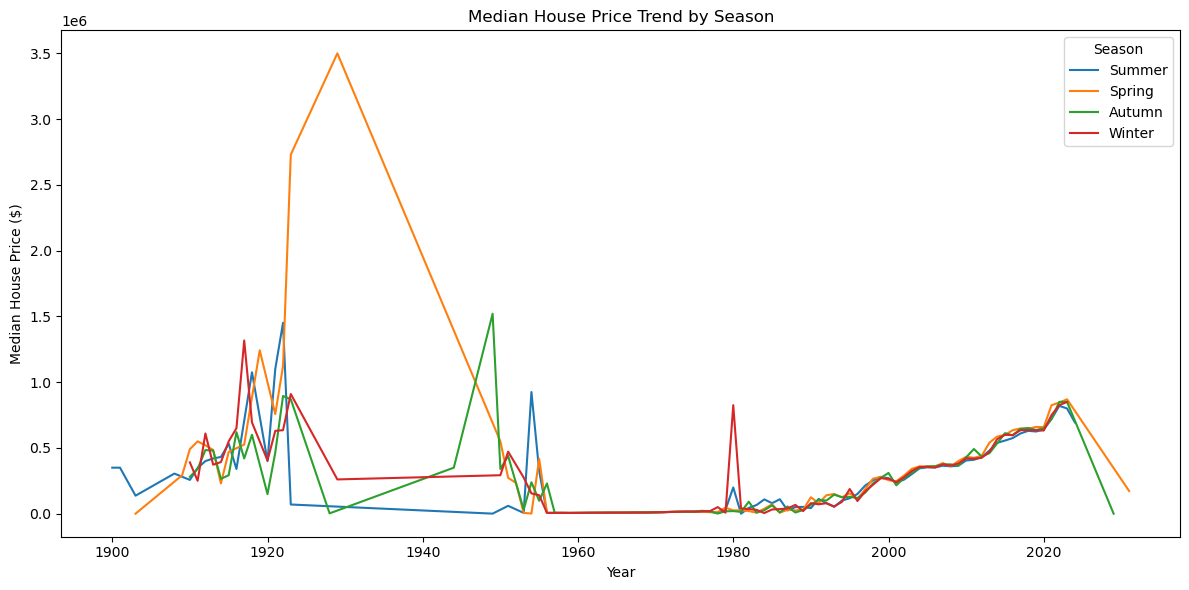

In [13]:
#Import libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt

#Only selecting what we need for analysis
price_date_df = prop_price_df.select("iso_contract_date","iso_settlement_date","purchase_price")

#Some years are clearly incorrect, they go as far back as year 0015. Every year before 1900 will be deemed incorrect.
#It will be fixed by substituting its value with the value of settlement date (not 100% correct, but a more close approximation)
price_date_df = price_date_df.withColumn(
    "iso_contract_date",
    when(F.year("iso_contract_date") < 1900, col("iso_settlement_date"))
    .otherwise(col("iso_contract_date"))
)

#Extracting year/month from the contract date
price_date_df = price_date_df.withColumn("year", F.year("iso_contract_date")) \
                    .withColumn("month", F.month("iso_contract_date"))

#Creating new "season" feature from the date
seasons_df = price_date_df.withColumn(
    "season",
    when(F.col("month").isin(9,10,11), "Spring")
    .when(F.col("month").isin(12,1,2), "Summer")
    .when(F.col("month").isin(3,4,5), "Autumn")
    .when(F.col("month").isin(6,7,8), "Winter")
)

#Calculating median price for each year, in each season
seasons_df = seasons_df.groupBy("year", "season").agg(
    F.median("purchase_price").alias("median_price")
).orderBy("year", "season")

seasons_df = seasons_df.select("year","season","median_price")#selecting only required fields

#Drop remaining values out of the range we defined (from 1900 onwards)- we were not able to fix those
seasons_df = seasons_df.filter( F.col("year") >= 1900)

#Convert the small, aggregated result to a Pandas DataFrame
seasons_pd = seasons_df.toPandas()

plt.figure(figsize=(12,6))
sns.lineplot(data=seasons_pd, x="year", y="median_price", hue="season")
plt.title("Median House Price Trend by Season")
plt.ylabel("Median House Price ($)")
plt.xlabel("Year")
plt.legend(title="Season")
plt.tight_layout()
plt.show()


**NOTE:** The period between 1900 and 1960 shows noticeably unstable trends, likely due to the smaller number of available data points for these earlier years. In contrast, more recent years have a larger sample size, and the seasonal price trends appear much more consistent, following a similar overall pattern as expected

2.2.5 (Open Question) Explore the dataset freely and plot one diagram of your choice. Which columns (at least 2) are highly correlated to the sales price? Discuss the steps of your exploration and the results. (No word limit, please keep concise.) 

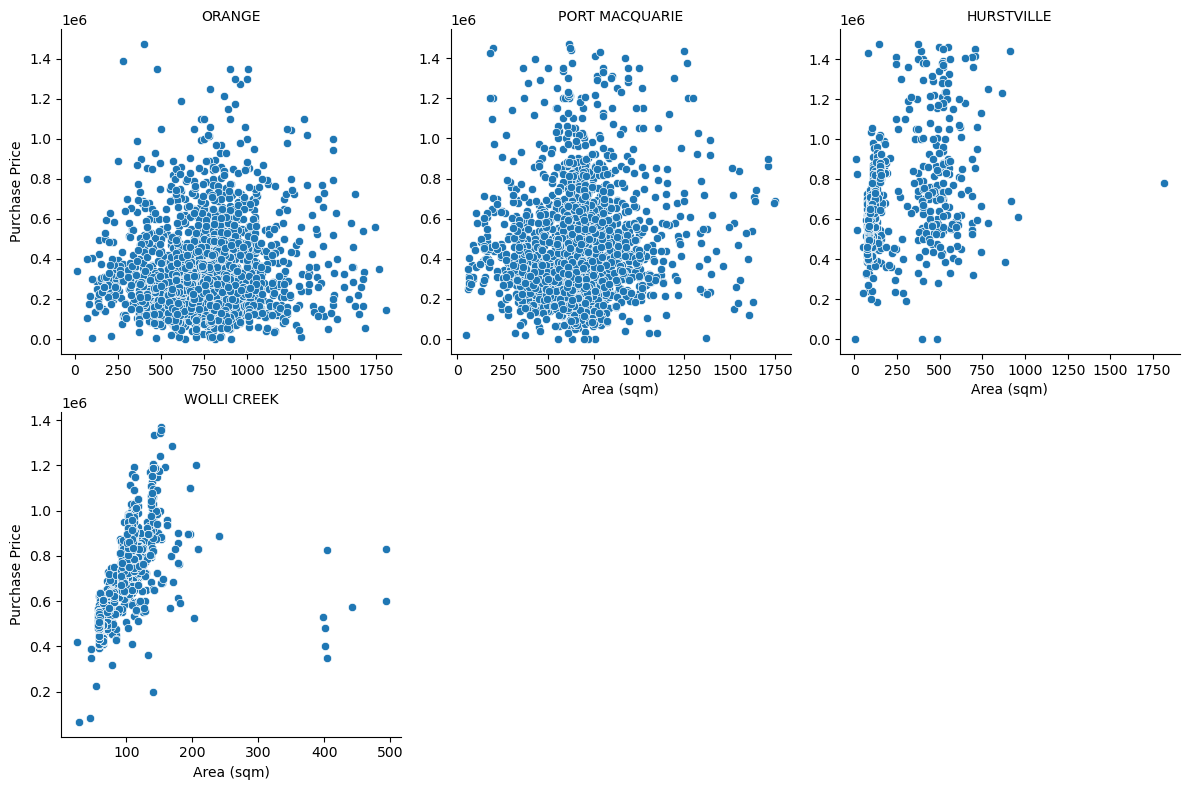

In [14]:
#Adding suburb column as a feature (might be correlated to sales price)
prop_price_df_2 = prop_price_df.withColumn("suburb", F.split(F.col("address"), ",\s*").getItem(1)) #adding suburb
sample_df = prop_price_df_2.select("suburb", "area_sqm", "purchase_price").sample(0.1).toPandas()

#Calculating quantiles for outliers filtering
Q1_price = sample_df["purchase_price"].quantile(0.25)
Q3_price = sample_df["purchase_price"].quantile(0.75)
IQR_price = Q3_price - Q1_price

Q1_area = sample_df["area_sqm"].quantile(0.25)
Q3_area = sample_df["area_sqm"].quantile(0.75)
IQR_area = Q3_area - Q1_area

# Getting rid of outliers (IQR approach)
lower_price = Q1_price - 1 * IQR_price
upper_price = Q3_price + 1 * IQR_price

lower_area = Q1_area - 1 * IQR_area
upper_area = Q3_area + 1 * IQR_area

#Filtering outliers to see the trends properly
filtered_sample = sample_df[
    (sample_df["purchase_price"] >= Q1_price - 1.5*IQR_price) &
    (sample_df["purchase_price"] <= Q3_price + 1.5*IQR_price) &
    (sample_df["area_sqm"] >= Q1_area - 1.5*IQR_area) &
    (sample_df["area_sqm"] <= Q3_area + 1.5*IQR_area)
]

top_suburbs = filtered_sample['suburb'].value_counts().head(4).index.tolist()
filtered_sample_top = filtered_sample[filtered_sample['suburb'].isin(top_suburbs)]

#Faceted scatterplot of purchase_price to square meters for each suburb
g = sns.FacetGrid(filtered_sample_top, col="suburb", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="area_sqm", y="purchase_price")
g.set_axis_labels("Area (sqm)", "Purchase Price")
g.set_titles("{col_name}")
plt.show()


While the relation is not always linear, it is evident that some suburbs like Kellyville, Hurstville exhibit strong linear patterns between the square meters area of the apartment and the purchase price. This shows 2 things:
-  a possible linear relation between area and purchase Price
-  since the relationship between area and purchase price is very different from suburb to suburb, it is clear that the suburb also has an important influence on influencing the house prices

Both area and suburb are highly correlated to the purchase_price label.

### Part 3 RDDs vs DataFrame vs Spark SQL (25%) <a class="anchor" name="part-3"></a>
Implement the following complex queries using RDD, DataFrame in SparkSQL separately(choose two). Log the time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 2 approaches of your choice.
(notes: You can write a multi-step query or a single complex query, the choice is yours. You can reuse the data frame in Part 2.)

#### Complex Query:
<pre>
A property investor wants to understand whether the property price and the settlement date are correlated. Here is the conditions:
1)	The investor is only interested in the last 2 years of the dataset.
2)	The investor is looking at houses under $2 million.
3)	Perform a bucketing of the settlement date (settlement – contract date
range (15, 30, 45, 60, 90 days).
4)	Perform a bucketing of property prices in $500K(e.g. 0-$500K, $500K-$1M, $1M-$1.5M, $1.5-$2M)
5)	Count the number of transactions in each combination and print the result in the following format
(Note: It’s fine to count the same property multiple times in this task, it’s based on sales transactions).
(Note: You shall show the full table with 40 rows, 2 years *4 price bucket * 5 settlement bucket; 0 count should be displayed as 0, not omitted.)
</pre>

### a)	Implement the above query using two approaches of your choice separately and print the results. (Note: Outputs from both approaches of your choice are required, and the results should be the same.). 

#### 3.1. Implementation 1

In [16]:
%%time

#Filtering only the part of the df we are interested in
df_last_two = prop_price_df.filter(
    (F.col("purchase_price") < 2000000) &
    (
     (F.year("iso_settlement_date") >= (F.year(F.current_date()) - 2)) &
     (F.year("iso_settlement_date") <= F.year(F.current_date()) )
    )
)

#Creating settlemet days feature
df_last_two = df_last_two.withColumn(
    "settlement_days",
    F.datediff("iso_settlement_date", "iso_contract_date")
)

#Bucketing the settlement days into (15,30,45,60,90)
df_last_two = df_last_two.withColumn(
    "settlement_days",
     F.when(F.col("settlement_days") <= 30, "0–30 days") #0-15 range does not make much sense in property sales (most times settlements are over 15 days)
     .when(F.col("settlement_days") <= 45, "31–45 days")
     .when(F.col("settlement_days") <= 60, "46–60 days")
     .when(F.col("settlement_days") <= 90, "61–90 days")
     .otherwise("90+ days")
)

#Bucketing the price range into (500K,1M,1.5M,2M)
df_last_two = df_last_two.withColumn(
    "price_range",
    F.when(F.col("purchase_price") < 500000, "0–500K")
     .when(F.col("purchase_price") < 1000000, "500K–1M")
     .when(F.col("purchase_price") < 1500000, "1M–1.5M")
     .when(F.col("purchase_price") < 2000000, "1.5M–2M")
)

#Grouping and finding the count for each combo of year, price_range and transaction count
agg_df = (df_last_two
    .groupBy(F.year("iso_settlement_date").alias("year"), "price_range", "settlement_days")
    .agg(F.count("*").alias("transaction_count"))
)

#Ordering (note that order for price_range is not perfect since it orders alphabetically)
agg_df = agg_df.orderBy(F.col("year").asc(), F.col("price_range").asc(),F.col("settlement_days").asc())

agg_df.show(40, truncate=False)

+----+-----------+---------------+-----------------+
|year|price_range|settlement_days|transaction_count|
+----+-----------+---------------+-----------------+
|2023|0–500K     |0–30 days      |11714            |
|2023|0–500K     |31–45 days     |11027            |
|2023|0–500K     |46–60 days     |2513             |
|2023|0–500K     |61–90 days     |1759             |
|2023|0–500K     |90+ days       |9031             |
|2023|1.5M–2M    |0–30 days      |1743             |
|2023|1.5M–2M    |31–45 days     |5092             |
|2023|1.5M–2M    |46–60 days     |2367             |
|2023|1.5M–2M    |61–90 days     |2685             |
|2023|1.5M–2M    |90+ days       |2396             |
|2023|1M–1.5M    |0–30 days      |4757             |
|2023|1M–1.5M    |31–45 days     |12382            |
|2023|1M–1.5M    |46–60 days     |4824             |
|2023|1M–1.5M    |61–90 days     |4607             |
|2023|1M–1.5M    |90+ days       |4143             |
|2023|500K–1M    |0–30 days      |17162       

#### 3.2. Implementation 2

In [17]:
%%time
prop_price_df.createOrReplaceTempView("property")

#SQL version
query = """
WITH filtered AS (
    SELECT
        year(iso_settlement_date) AS year,
        datediff(iso_settlement_date, iso_contract_date) AS settlement_days,
        purchase_price
    FROM property
    WHERE purchase_price < 2000000
      AND year(iso_settlement_date) >= year(current_date()) - 2
),
bucketed AS (
    SELECT
        year,
        CASE
            WHEN settlement_days <= 30 THEN '0-30 days'
            WHEN settlement_days <= 45 THEN '31–45 days'
            WHEN settlement_days <= 60 THEN '46–60 days'
            WHEN settlement_days <= 90 THEN '61–90 days'
            ELSE '90+ days'
        END AS settlement_days,
        CASE
            WHEN purchase_price < 500000 THEN '0–500K'
            WHEN purchase_price < 1000000 THEN '500K–1M'
            WHEN purchase_price < 1500000 THEN '1M–1.5M'
            WHEN purchase_price < 2000000 THEN '1.5M–2M'
        END AS price_range
    FROM filtered
),
counts AS (
    SELECT year, price_range, settlement_days, COUNT(*) AS transaction_count
    FROM bucketed
    GROUP BY year, price_range, settlement_days
)
SELECT year, price_range, settlement_days, transaction_count
FROM counts
ORDER BY year, price_range, settlement_days
"""

sql_result = spark.sql(query)
sql_result.show(40, truncate=False)

+----+-----------+---------------+-----------------+
|year|price_range|settlement_days|transaction_count|
+----+-----------+---------------+-----------------+
|2023|0–500K     |0-30 days      |11714            |
|2023|0–500K     |31–45 days     |11027            |
|2023|0–500K     |46–60 days     |2513             |
|2023|0–500K     |61–90 days     |1759             |
|2023|0–500K     |90+ days       |9031             |
|2023|1.5M–2M    |0-30 days      |1743             |
|2023|1.5M–2M    |31–45 days     |5092             |
|2023|1.5M–2M    |46–60 days     |2367             |
|2023|1.5M–2M    |61–90 days     |2685             |
|2023|1.5M–2M    |90+ days       |2396             |
|2023|1M–1.5M    |0-30 days      |4757             |
|2023|1M–1.5M    |31–45 days     |12382            |
|2023|1M–1.5M    |46–60 days     |4824             |
|2023|1M–1.5M    |61–90 days     |4607             |
|2023|1M–1.5M    |90+ days       |4143             |
|2023|500K–1M    |0-30 days      |17162       

### b)	Which one is easier to implement, in your opinion? Log the time taken for each query, and observe the query execution time, among DataFrame and SparkSQL, which is faster and why? Please include proper references. (Maximum 500 words.) 

Between DataFrame and SparkSQL, I found the SparkSQL version easier to implement, as it relies on simple SQL query language and it makes both the bucketing and counting more streamlined.

For both queries, the total elapsed time (wall time) is almost identical (5.64 against 5.73), with the SQL version being only slightly faster. The difference comes from how the two APIs interpret and build the execution plan:
-  SparkSQL takes the SQL string, parses it, and directly converts it into a logical plan, which the Catalyst optimizer then turns into a physical plan. This step is relatively lightweight at the driver level.

-  DataFrame API builds the logical plan programmatically, which involves creating intermediate objects (e.g., agg_df, last_two_df) and chaining transformations. This introduces a small amount of driver-side overhead before the plan is optimized and executed, which we can see by looking at the additional system and CPU times in the DataFrame version.

However, once the plan is submitted to Spark, both are optimized in the same way by Catalyst and executed on the same distributed engine (Armbrust et al., 2015). That’s why the wall times are very close — the main cost lies in distributed execution (scheduling, I/O, shuffling), not in the driver’s overhead.

On the other hand, if we compare DataFrames and SparkSQL to RDDs, the performance difference is much more pronounced. Catalyst optimization and Tungsten execution improvements apply only to DataFrames and Datasets, while RDDs lack these features (Xin et al., 2015). Although RDDs offer more control over partitioning and custom processing, they generally perform worse for structured workloads and are not recommended for most modern Spark applications (Damji et al.,2016) .

### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html